In [1]:
#Import some packages that we will need
import torch
import matplotlib.pyplot as plt
import pint
import numpy as np
import cv2
from tqdm import tqdm

u = pint.UnitRegistry()

plt.style.use(['science','notebook'])

%matplotlib ipympl

In [2]:
#Wavelength
wavelength = 660 * u.nm

#Propagation Distance
z = 10.0 * u.cm

#Wavenumber (k)
wavenumber = 2*np.pi/wavelength

#Image width and height (assume square)
w = 224
h = w

#Spatial Extent (This follows from SLM parameters)
x_extent = 8.0 * u.mm
y_extent = x_extent

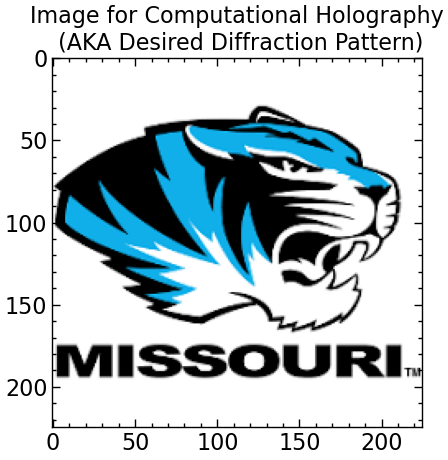

In [3]:
#Read in our image
image = cv2.imread('../images/mizzou.png')

#Quick view of the image
plt.imshow(image)
plt.title('Image for Computational Holography\n (AKA Desired Diffraction Pattern)')
plt.show()

/home/marshall/miniconda3/envs/sci/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:701: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)


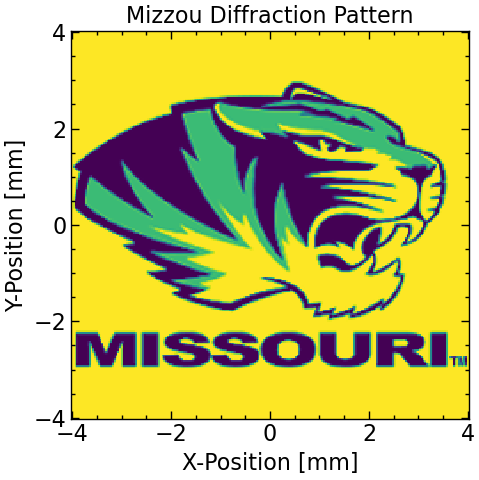

In [4]:
#Give the image a spatial dimension
x = np.linspace(-x_extent/2, x_extent/2, w)
y = x
xx,yy = np.meshgrid(x,y)

image = cv2.resize(image, dsize=(len(x), len(y)), interpolation=cv2.INTER_CUBIC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

U0 = np.asarray(image)
U0 = np.flip(U0, 0) / np.max(U0)

plt.figure(figsize=(5,5))
plt.pcolormesh(xx,yy,U0)
plt.xlabel('X-Position [mm]')
plt.ylabel('Y-Position [mm]')
plt.title("Mizzou Diffraction Pattern")
plt.tight_layout()
plt.show()

In [5]:
#Create our frequency space
kx = np.fft.fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi # multiply by 2pi to get angular frequency
kxv, kyv = np.meshgrid(kx,kx)

In [6]:
#Create a propagation function
def propagate(input_wavefront, wavenumber, distance):
    H = np.exp(1j * wavenumber * distance) * np.exp(1j* (distance) * np.sqrt(wavenumber**2 - (kxv)**2 - (kyv)**2))
    A = np.fft.fft2(input_wavefront)
    A = np.fft.fftshift(A)
    U_ = A * H
    U_ = np.fft.ifftshift(U_.magnitude)
    return(np.fft.ifft2(U_))

In [7]:
def gsa(wavenumber, desired_image, distance, iterations=1000):
    
    original_amplitude = np.ones((w,h))
    original_phase = np.ones((w,h))
    original_wavefront = original_amplitude * np.exp(1j * original_phase)
    u1 = original_wavefront
    
    for i in tqdm(range(iterations), desc="Gerchberg-Saxton Algorithm"):
        
        #Prop to the image plane
        u0 = propagate(u1, wavenumber, distance)
        u0_phase = np.angle(u0)
        
        #Replace the amplitude with desired image
        u0 = desired_image * np.exp(1j * u0_phase)
        
        #Prop to the diffractive plane
        u1 = propagate(u0, wavenumber, -distance)
        u1_phase = np.angle(u1)
        #Replace the amplitude with the original amplitude

        u1 = original_amplitude * np.exp(1j * u1_phase)

    return u1

In [ ]:
#Run GSA
forward_wavefront = gsa(wavenumber, U0, z, 2000)

Gerchberg-Saxton Algorithm:  19%|██████████████████████████▉                                                                                                                    | 376/2000 [00:07<00:30, 52.90it/s]

In [ ]:
diffraction_pattern = propagate(forward_wavefront, wavenumber, z)

In [ ]:
#Plot it to see the diffraction pattern
plt.figure(figsize=(5,5))
plt.pcolormesh(xx,yy,np.abs(diffraction_pattern)**2)
plt.xlabel('X-Position [mm]')
plt.ylabel('Y-Position [mm]')
plt.title("Tiger Diffraction Pattern")
plt.tight_layout()
plt.show()

# Wavefront Animation

In [ ]:
from matplotlib.animation import FuncAnimation

def animate(frame_num):
    img = np.abs(data[frame_num])**2
    im.set_array(img.ravel())
    ax.set_title(f"Tiger Diffraction Pattern\nScreen Distance: {(frame_num+1) * z / 100}")
    return im

In [ ]:
data = []
propagation_distances = np.linspace(0,z,100)
for z_ in tqdm(propagation_distances, desc="Sampling Wavefront"):
    data.append(propagate(forward_wavefront, wavenumber, z_))
    
data = np.asarray(data)
min_ = np.min(np.abs(data))
max_ = np.max(np.abs(data))

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(5,5))
im = ax.pcolormesh(xx,yy,np.abs(data[0])**2, vmin=min_, vmax=max_)
ax.set_xlabel('X-Position [mm]')
ax.set_label('Y-Position [mm]')
ax.set_title(f"Tiger Diffraction Pattern\nScreen Distance: {0 * z}")
plt.tight_layout()
anim = FuncAnimation(fig, animate, frames=len(data), interval=100, repeat=False)
plt.show()